In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy import sparse
from tabulate import tabulate  # Import tabulate
import warnings

warnings.filterwarnings("ignore")


In [2]:
# Load the dataset
df = pd.read_csv("PDP.csv")
df = df.dropna(subset=["Domain", "label"])
df.columns = df.columns.str.strip()  # Removes leading/trailing spaces

In [3]:
X_text = df["Domain"].astype(str)
y = df["label"]


In [4]:
# Step 2: TF-IDF Vectorization (character-level)
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 5))
X_vec = vectorizer.fit_transform(X_text)


In [5]:
# Step 3: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_vec, y, test_size=0.2, random_state=42
)

In [6]:
# --- Logistic Regression ---
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Training Accuracy (Logistic Regression)
y_train_pred_log = log_model.predict(X_train)
train_accuracy_log = accuracy_score(y_train, y_train_pred_log)
#print(f"\nLogistic Regression - Training Accuracy: {train_accuracy_log:.4f}")

# Testing Accuracy (Logistic Regression)
y_test_pred_log = log_model.predict(X_test)
test_accuracy_log = accuracy_score(y_test, y_test_pred_log)
#print(f"Logistic Regression - Testing Accuracy: {test_accuracy_log:.4f}")

In [7]:
# --- SGDClassifier ---
sgd_model = SGDClassifier(loss='log_loss', max_iter=1000, random_state=42)
sgd_model.fit(X_train, y_train)

# Training Accuracy (SGDClassifier)
y_train_pred_sgd = sgd_model.predict(X_train)
train_accuracy_sgd = accuracy_score(y_train, y_train_pred_sgd)
#print(f"\nSGDClassifier - Training Accuracy: {train_accuracy_sgd:.4f}")

# Testing Accuracy (SGDClassifier)
y_test_pred_sgd = sgd_model.predict(X_test)
test_accuracy_sgd = accuracy_score(y_test, y_test_pred_sgd)
#print(f"SGDClassifier - Testing Accuracy: {test_accuracy_sgd:.4f}")

In [8]:
table = [
    ["Model", "Train Accuracy", "Test Accuracy"],
    ["Logistic Regression", train_accuracy_log, test_accuracy_log],
    ["SGDClassifier", train_accuracy_sgd, test_accuracy_sgd],
]

# Print the table
print(tabulate(table, headers="firstrow", tablefmt="grid"))

+---------------------+------------------+-----------------+
| Model               |   Train Accuracy |   Test Accuracy |
+=====================+==================+=================+
| Logistic Regression |         0.920386 |        0.906381 |
+---------------------+------------------+-----------------+
| SGDClassifier       |         0.880277 |        0.880744 |
+---------------------+------------------+-----------------+


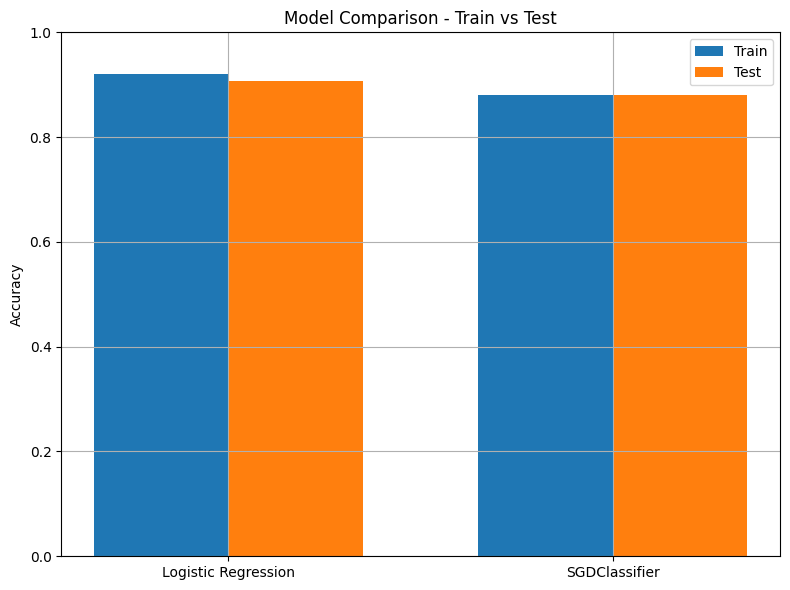

In [9]:
# Model Comparison
accuracies_train = {
    "Logistic Regression": train_accuracy_log,
    "SGDClassifier": train_accuracy_sgd,
}
accuracies_test = {
    "Logistic Regression": test_accuracy_log,
    "SGDClassifier": test_accuracy_sgd,
}

labels = list(accuracies_train.keys())
train_scores = [accuracies_train[l] for l in labels]
test_scores = [accuracies_test[l] for l in labels]

x = range(len(labels))
width = 0.35

plt.figure(figsize=(8, 6))
plt.bar(x, train_scores, width, label='Train')
plt.bar([p + width for p in x], test_scores, width, label='Test')

plt.ylabel('Accuracy')
plt.title('Model Comparison - Train vs Test')
plt.xticks([p + width / 2 for p in x], labels)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Compare and pick the best (based on TESTING accuracy)
accuracies = {
    "Logistic Regression": test_accuracy_log,
    "SGDClassifier": test_accuracy_sgd,
}

best_model_name = max(accuracies, key=accuracies.get)
best_model_accuracy = accuracies[best_model_name]
print(
    f"\nBest model: {best_model_name} with Testing Accuracy:"
    f" {best_model_accuracy:.4f}"
)


Best model: Logistic Regression with Testing Accuracy: 0.9064


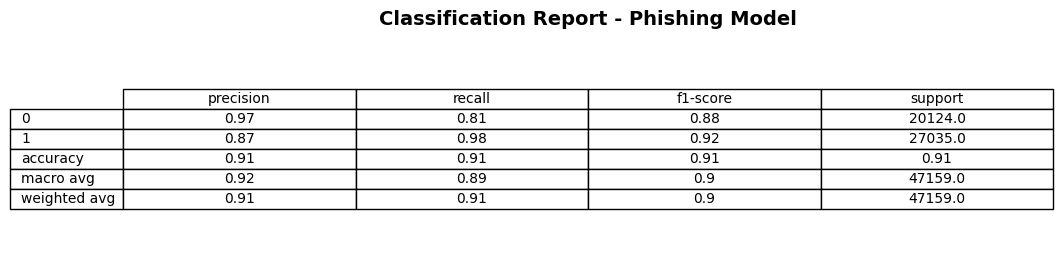

In [11]:
# Retrain and test the best model
if best_model_name == "Logistic Regression":
    best_model = LogisticRegression(max_iter=1000)
elif best_model_name == "SGDClassifier":
    best_model = SGDClassifier(loss='log_loss', max_iter=1000, random_state=42)

# Retrain the best model
best_model.fit(X_train, y_train)

# Evaluate again
y_pred_best_final = best_model.predict(X_test)
report = classification_report(y_test, y_pred_best_final, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Visualize as table
plt.figure(figsize=(10, len(df_report)*0.6))
plt.axis('off')
plt.title("Classification Report - Phishing Model", fontsize=14, fontweight='bold')
table = plt.table(cellText=df_report.round(2).values,
                  colLabels=df_report.columns,
                  rowLabels=df_report.index,
                  loc='center',
                  cellLoc='center',
                  colLoc='center')
table.scale(1.2, 1.2)
plt.show()

In [12]:
# VISUALIZATION 
label_counts = df['label'].value_counts()

In [13]:
# Count phishing vs legitimate URL
phishing_urls = df[df["label"] == 0].shape[0]
legitimate_urls = df[df["label"] == 1].shape[0]

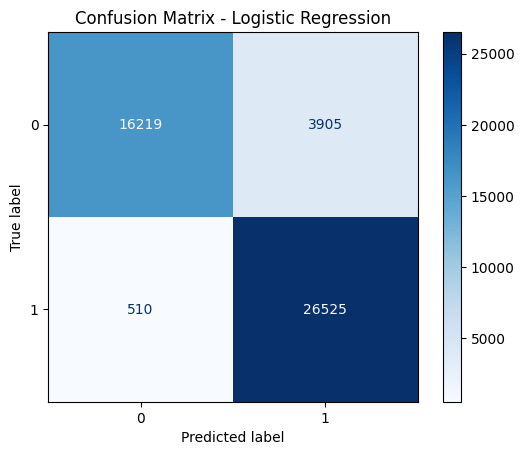

In [14]:
#Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best_final, cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

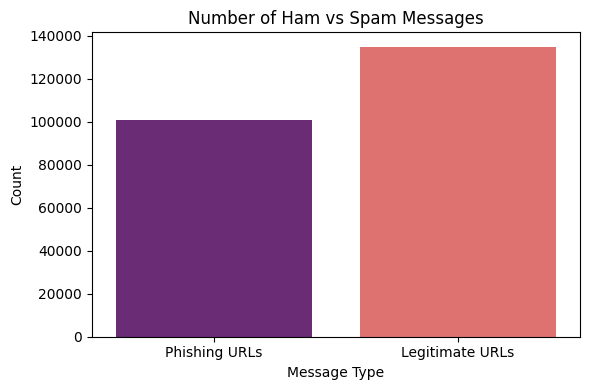

In [15]:
plt.figure(figsize=(6,4))
sns.barplot(x=["Phishing URLs", "Legitimate URLs"], 
            y=[phishing_urls, legitimate_urls], 
            palette="magma")
plt.title('Number of Ham vs Spam Messages')
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import joblib
import re
from urllib.parse import urlparse
import numpy as np

# Feature extractor (must match backend)
def extract_features(url):
    parsed = urlparse(url)
    return [
        len(url),
        url.count('.'),
        1 if re.search(r'\d+\.\d+\.\d+\.\d+', url) else 0,
        url.count('-'),
        url.count('/'),
        1 if parsed.scheme == 'https' else 0
    ]

# Apply feature extraction
df = df.dropna(subset=["Domain", "label"])
X = np.array(df["Domain"].apply(lambda x: extract_features(str(x))).tolist())
y = df["label"].astype(int)

# Train-test split and model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)

# Save model
joblib.dump(model, "phishing_url_model.pkl")
print("✅ Phishing URL model saved.")

✅ Phishing URL model saved.
